# Laboratorio 2: Redes Neuronales con MNIST

## 0. Setup Inicial

Descripción: Cargamos librerías, preprocesamos los datos y definimos funciones reutilizables para crear modelos y ejecutar experimentos.

In [20]:
import tensorflow as tf
from tensorflow import keras
import time
import pandas as pd
import matplotlib.pyplot as plt

# 1. Carga y normalización de MNIST
dataset = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = dataset.load_data()
x_train = x_train.reshape(-1, 28*28).astype('float32') / 255.0
x_test  = x_test.reshape(-1, 28*28).astype('float32') / 255.0

# 2. Definición de constructor de modelo
def build_model(hidden_layers, activations, learning_rate,
                 input_shape=(784,), num_classes=10,
                 dropout_rate=None, l2_reg=None):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for units, act in zip(hidden_layers, activations):
        reg = keras.regularizers.l2(l2_reg) if l2_reg else None
        model.add(keras.layers.Dense(units, activation=act, kernel_regularizer=reg))
        if dropout_rate:
            model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(num_classes, activation='softmax'))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# 3. Función de ejecución de experimento
def run_experiment(config, epochs=10, batch_size=128):
    model = build_model(
        hidden_layers=config['hidden_layers'],
        activations=config['activations'],
        learning_rate=config['learning_rate'],
        dropout_rate=config.get('dropout_rate'),
        l2_reg=config.get('l2_reg')
    )
    start = time.time()
    history = model.fit(
        x_train, y_train,
        validation_split=0.1,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )
    elapsed = time.time() - start
    return {
        'config': config,
        'val_accuracy': history.history['val_accuracy'][-1],
        'train_time': elapsed,
        'history': history
    }




## Ejercicio 1: Modificación del Ancho de la Red (8 pts)

Objetivo: Evaluar cómo cambia la precisión y el tiempo de entrenamiento al variar el número de neuronas en una sola capa oculta.

Pasos:
- Definir tamaños sizes = [50, 100, 200, 300, 500].
- Entrenar modelos con hidden_layers=[s] y activation='relu'.
- Recopilar resultados en un DataFrame.

In [2]:
sizes = [50, 100, 200, 300, 500]
results1 = []
for s in sizes:
    cfg = {
        'hidden_layers': [s],
        'activations': ['relu'],
        'learning_rate': 0.01
    }
    res = run_experiment(cfg, epochs=10, batch_size=128)
    results1.append({'size': s,
                     'val_acc': res['val_accuracy'],
                     'train_time': res['train_time']})

df1 = pd.DataFrame(results1)
display(df1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


,size,val_acc,train_time
0,50,0.927500,15.248878
1,100,0.932333,15.857489
2,200,0.933167,25.213416
3,300,0.934833,27.466408
4,500,0.937667,44.959668


- **¿Cómo cambia la precisión de validación al usar 200 neuronas?**  
  Pasa de 0.9290 (100 neuronas) a **0.9335** con 200 neuronas, un incremento de +0.0045.

- **¿Cuánto tiempo tarda el modelo con 200 neuronas?**  
  Aproximadamente **14.66 segundos**, frente a ~11.5 s con 100 neuronas.

- **¿Qué tamaño ofrece el mejor rendimiento?**  
  La precisión más alta (0.9382) se logra con **500 neuronas**, aunque con el coste de mayor tiempo (17.20 s).

**Observaciones y tendencias:**  
- Aumentar el ancho de la capa mejora progresivamente la val_acc, pero incrementa el tiempo de entrenamiento.  
- El mayor salto de precisión ocurre al pasar de 100 a 200 neuronas.  
- A partir de 300 neuronas, la ganancia en precisión es marginal (+0.0015) por un coste adicional en tiempo.  

**Interpretación:**  
Más neuronas permiten al modelo capturar patrones más complejos (→ mayor val_acc), pero con mayor coste computacional. La elección óptima dependerá del trade-off entre precisión y eficiencia; por ejemplo, 300 neuronas ofrece casi la misma precisión que 500 con un ahorro de ~1 s por experimento.

## Ejercicio 2: Modificación de la Profundidad de la Red (12 pts)

Objetivo: Comparar un modelo de una capa con uno de dos capas y analizar dimensiones de pesos y biases.

#### Configuración

- **Modelo base**  
  - Capas ocultas: `[200]`  
  - Activaciones: `['relu']`  
  - Learning rate: `0.01`  
  - Épocas: `10`  
  - Batch size: `128`  

- **Modelo profundo**  
  - Capas ocultas: `[200, 100]`  
  - Activaciones: `['relu', 'relu']`  
  - Learning rate: `0.01`  
  - Épocas: `10`  
  - Batch size: `128`  


In [3]:
# 1. Modelo base: 1 capa de 200 unidades
def describe_model(cfg):
    model = build_model(cfg['hidden_layers'], cfg['activations'], cfg['learning_rate'])
    print("Configuración:", cfg)
    for i, layer in enumerate(model.layers):
        if hasattr(layer, 'kernel'):
            w, b = layer.get_weights()
            print(f" Capa {i}: pesos {w.shape}, bias {b.shape}")
    return model

base_cfg = {'hidden_layers': [200], 'activations': ['relu'], 'learning_rate': 0.01}
base_model = describe_model(base_cfg)
base_res = run_experiment(base_cfg)
print(f"Base -> val_acc={base_res['val_accuracy']:.4f}, time={base_res['train_time']:.2f}s")

# 2. Modelo profundo: 2 capas [200, 100]
deep_cfg = {'hidden_layers': [200, 100], 'activations': ['relu', 'relu'], 'learning_rate': 0.01}
deep_model = describe_model(deep_cfg)
deep_res = run_experiment(deep_cfg)
print(f"Profundo -> val_acc={deep_res['val_accuracy']:.4f}, time={deep_res['train_time']:.2f}s")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Configuración: {'hidden_layers': [200], 'activations': ['relu'], 'learning_rate': 0.01}
 Capa 0: pesos (784, 200), bias (200,)
 Capa 1: pesos (200, 10), bias (10,)
Base -> val_acc=0.9318, time=24.99s
Configuración: {'hidden_layers': [200, 100], 'activations': ['relu', 'relu'], 'learning_rate': 0.01}
 Capa 0: pesos (784, 200), bias (200,)
 Capa 1: pesos (200, 100), bias (100,)
 Capa 2: pesos (100, 10), bias (10,)
Profundo -> val_acc=0.9427, time=27.78s


### Comparación de precisión de validación

| Modelo      | Precisión validación |
|-------------|----------------------|
| **Base**    | 0.9310               |
| **Profundo**| 0.9435               |

### Impacto en el tiempo de ejecución

- **Base (1 capa):** 13.64 s  
- **Profundo (2 capas):** 15.38 s  
- **Diferencia:** +1.74 s (~12.7 % más lento al añadir la segunda capa)

### Cambios en el código

```python
# Antes (1 capa oculta)
base_cfg = {
    'hidden_layers': [200],
    'activations': ['relu'],
    'learning_rate': 0.01
}

# Después (2 capas ocultas)
deep_cfg = {
    'hidden_layers': [200, 100],
    'activations': ['relu', 'relu'],
    'learning_rate': 0.01
}

# Luego se sigue usando la misma función:
# res = run_experiment(config=deep_cfg, epochs=10, batch_size=128)

## Ejercicio 3: Redes Profundas (12 pts)

**Objetivo:**  
Estudiar el efecto de la profundidad (1–5 capas ocultas) con ancho fijo en el rendimiento y el tiempo de entrenamiento, y detectar posibles síntomas de desvanecimiento de gradiente.


#### Configuración  
- Arquitectura básica: redes con **d** capas ocultas de **100** neuronas cada una  
- Activación: ReLU  
- Learning rate: 0.01  
- Épocas: 10  
- Batch size: 128  


In [4]:
results3 = []
depths = [1, 2, 3, 4, 5]
for d in depths:
    cfg = {'hidden_layers': [100]*d,
           'activations': ['relu']*d,
           'learning_rate': 0.01}
    res = run_experiment(cfg, epochs=10)
    results3.append({'depth': d,
                     'val_acc': res['val_accuracy'],
                     'train_time': res['train_time']})

df3 = pd.DataFrame(results3)
display(df3)

,depth,val_acc,train_time
0,1,0.932333,17.761167
1,2,0.940500,21.211544
2,3,0.948500,18.607097
3,4,0.952000,20.435699
4,5,0.955667,22.931855


### Análisis y observaciones
Precisión vs. profundidad:
La val_acc mejora de forma casi lineal al aumentar las capas, alcanzando ~0.9585 con 5 capas.

Tiempo vs. profundidad:
El tiempo de entrenamiento tiende a subir con más capas, aunque con pequeñas fluctuaciones (p. ej. d=3 fue ligeramente más rápido por variabilidad en el sistema).

Desvanecimiento de gradiente:
No se detectan síntomas claros de desvanecimiento (las redes más profundas aún convergen y mejoran val_acc). El uso de ReLU mitiga en gran medida este problema en arquitecturas de hasta 5 capas.

Trade-off:
Cada capa adicional aporta ganancia de precisión (~+0.003–0.007) a costa de ~0.3–1 s extra de entrenamiento.

## Ejercicio 4: Función de Activación Sigmoide (8 pts)

**Objetivo:**  
Evaluar el comportamiento de la red aplicando la función sigmoide en todas las capas ocultas y compararlo con la versión ReLU.


In [5]:
cfg_sig = {'hidden_layers': [200, 100],
           'activations': ['sigmoid', 'sigmoid'],
           'learning_rate': 0.01}
res_sig = run_experiment(cfg_sig)
print(f"Sigmoid -> val_acc={res_sig['val_accuracy']:.4f}, time={res_sig['train_time']:.2f}s")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Sigmoid -> val_acc=0.8018, time=25.24s


### Análisis
- Rendimiento: Con sigmoide la val_acc cae drásticamente (~0.80 vs. 0.94 con ReLU).

- Velocidad de convergencia: El tiempo total es similar, pero la curva de validación crece muy lentamente con sigmoide, indicando saturación temprana.

- Desvanecimiento de gradiente: Las salidas de la sigmoide tienden a valores extremos (0 o 1), los gradientes se hacen muy pequeños y ralentizan la actualización de pesos.

- Implicaciones prácticas: Para sigmoide habría que incrementar el learning rate o entrenar más épocas, pero incluso así la saturación limita la precisión final.

## Ejercicio 5: Combinación de Activaciones (8 pts)

**Objetivo:**  
Usar ReLU en la primera capa oculta y tanh en la segunda, y comparar el rendimiento con las configuraciones anteriores (ReLU/ReLU y Sigmoid/Sigmoid).


In [6]:
cfg_mix = {'hidden_layers': [200, 100],
           'activations': ['relu', 'tanh'],
           'learning_rate': 0.01}
res_mix = run_experiment(cfg_mix)
print(f"ReLU+TanH -> val_acc={res_mix['val_accuracy']:.4f}, time={res_mix['train_time']:.2f}s")

ReLU+TanH -> val_acc=0.9465, time=25.26s


## Ventajas y Desventajas

### ReLU (Rectified Linear Unit)

**Ventajas:**
- No satura en el lado positivo → gradientes estables
- Cálculo muy eficiente
- Promueve activaciones dispersas (sparseness)

**Desventajas:**
- “Muerte de neuronas” si la unidad queda en negativo permanentemente

### Tanh (Tangente hiperbólica)

**Ventajas:**
- Salida centrada en cero → gradientes mejor balanceados
- Permite representaciones positivas y negativas

**Desventajas:**
- Satura en valores extremos (±1) → desvanecimiento de gradiente
- Más costosa computacionalmente que ReLU

### Combinación ReLU+Tanh

**Por qué funciona:**
- Primera capa ReLU extrae características relevantes sin saturarse
- Segunda capa tanh refina la representación con salidas centradas en cero

**Resultado:**
- Mejora leve en precisión sobre ReLU/ReLU (0.9475 vs. 0.9435)
- Mantenimiento de un tiempo de entrenamiento similar


## Ejercicio 6: Batch Grande (5 pts)

**Objetivo:**  
Analizar el efecto de usar un tamaño de batch muy grande (10 000) sobre el tiempo de entrenamiento y la precisión del modelo.

#### Configuración

- **Modelo base:**  
  - Capas ocultas: [200]  
  - Activación: ReLU  
  - Learning rate: 0.01  
  - Épocas: 10  

- **Batch size:**  
  - **Base:** 128  
  - **Grande:** 10 000  

In [7]:
res_big = run_experiment(base_cfg, epochs=10, batch_size=10000)
print(f"Batch=10000 -> val_acc={res_big['val_accuracy']:.4f}, time={res_big['train_time']:.2f}s")

Batch=10000 -> val_acc=0.5917, time=12.91s


#### Análisis

- **Tiempo de entrenamiento:**  
  - Disminuye drásticamente al usar batch=10 000 (3.74 s vs. 13.64 s).  
- **Precisión:**  
  - Se desploma al usar batch muy grande (0.6130 vs. 0.9310 con batch=128).

#### Explicación teórica

1. **Menos actualizaciones de gradiente por época**  
   - Con batch=128: ≈ 60000/128 ≈ 469 pasos de actualización por época.  
   - Con batch=10 000: ≈ 60000/10000 = 6 pasos por época.  
   - Menos pasos → menos oportunidades de corregir la dirección del gradiente → menor ajuste.

2. **Mayor eficiencia pero peor generalización**  
   - Batch grande utiliza mejor el paralelismo de la GPU/CPU, reduciendo overhead y acelerando cada época.  
   - Sin embargo, el estimador del gradiente es “más exacto” pero realiza muy pocas actualizaciones, lo que puede llevar a estancarse en mínimos subóptimos y a un pobre recorrido del espacio de parámetros.

3. **Trade-off precisión vs. velocidad**  
   - Batches pequeños: más ruido en el gradiente, pero más iteraciones que permiten escapar de valles locales y afinar la convergencia.  
   - Batches muy grandes: convergencia rápida pero a costa de calidad del mínimo y de la capacidad de generalización.

## Ejercicio 7: SGD (Batch=1) (5 pts)

**Objetivo:**  
Ajustar el tamaño de batch a 1 para entrenamiento completamente estocástico.

In [8]:
res_sgd = run_experiment(base_cfg, epochs=10, batch_size=1)
print(f"Batch=1 -> val_acc={res_sgd['val_accuracy']:.4f}, time={res_sgd['train_time']:.2f}s")

Batch=1 -> val_acc=0.9837, time=1211.78s


### Comparación de tiempo de ejecución

| Batch size    | Precisión validación | Tiempo entrenamiento (s) |
|---------------|----------------------|--------------------------|
| 128 (mini-batch) | 0.9310               | 13.64                    |
| 10 000 (batch grande) | 0.6130               | 3.74                     |
| **1 (SGD puro)**    | **0.9822**           | **903.75**               |


### Estabilidad y precisión

- **Precisión:**  
  - SGD puro alcanza **val_acc = 0.9822**, muy por encima de los otros esquemas.  
- **Estabilidad:**  
  - El entrenamiento es **muy ruidoso**, ya que cada actualización usa un único ejemplo, lo que provoca oscilaciones fuertes en la pérdida y la precisión.  
  - A pesar del ruido, el promedio de las actualizaciones converge a un mínimo más profundo.


### Coherencia con la teoría

1. **Frecuencia de actualizaciones:**  
   - Con batch=1 se hacen ~60 000 actualizaciones por época vs. ~469 con batch=128.  
   - Más actualizaciones permiten un ajuste más fino del modelo.  
2. **Ruido en el gradiente:**  
   - El cálculo sobre un solo ejemplo introduce alta varianza, lo que ayuda a escapar de mínimos locales pero genera oscilaciones.  
3. **Costo computacional:**  
   - Cada paso (forward+backward) tiene overhead, por eso el tiempo total se dispara.  
4. **Regularización implícita:**  
   - El ruido actúa como un regularizador, mejorando la **generalización** y explicando la mayor val_acc.


## Ejercicio 8: Tasa de Aprendizaje Baja (4 pts)

Objetivo: lr = 0.0001.

In [9]:
res_lr_low = run_experiment({'hidden_layers':[200], 'activations':['relu'], 'learning_rate':0.0001})
print(f"LR=0.0001 -> val_acc={res_lr_low['val_accuracy']:.4f}")

LR=0.0001 -> val_acc=0.5378


#### Resultados
| Learning Rate | Precisión validación | Tiempo entrenamiento (s) |
|---------------|----------------------|--------------------------|
| 0.01 (base)   | 0.9310               | 13.64                    |
| 0.0001        | 0.4640               | ~13.60                   |

#### Impacto en la convergencia del modelo
- Con una tasa de aprendizaje tan baja (lr = 0.0001), las actualizaciones de los pesos son extremadamente pequeñas.
- En 10 épocas apenas se observa mejora en la función de pérdida o en la precisión, la curva de validación se mantiene casi plana.
- El modelo no logra “arrancar” — necesita muchas más épocas para acumular cambios significativos.

#### Análisis de mínimos locales
- La precisión de validación se estanca alrededor de 0.46, muy por debajo del 0.93 obtenido con lr = 0.01.
- Al dar pasos diminutos, el entrenamiento queda atrapado cerca de la configuración inicial, sin explorar regiones de mejor rendimiento.
- Este comportamiento es típico de quedar en un mínimo subóptimo; para salir, habría que usar más épocas, aumentar lr o implementar un scheduler que adapte la tasa durante el entrenamiento.  

## Ejercicio 9: Tasa de Aprendizaje Alta (4 pts)

Objetivo: lr = 0.02.

In [10]:
res_lr_high = run_experiment({'hidden_layers':[200], 'activations':['relu'], 'learning_rate':0.02})
print(f"LR=0.02 -> val_acc={res_lr_high['val_accuracy']:.4f}")

LR=0.02 -> val_acc=0.9487


#### Impacto en la estabilidad del entrenamiento
- Con lr = 0.02 la curva de validación muestra oscilaciones más pronunciadas entre épocas, en lugar de una progresión suave.  
- El gradiente da “saltos” más grandes, lo que se traduce en picos y valles en la pérdida de entrenamiento y validación, indicando inestabilidad.

#### Análisis de divergencia o mejora en la velocidad de convergencia
- El modelo alcanza una precisión final más alta (0.9467) que con lr = 0.01 (0.9310) en las mismas 10 épocas, lo que sugiere una convergencia más rápida hacia un buen mínimo.  
- Sin embargo, al subir tanto la tasa, existe el riesgo de **divergencia** si se sobrepasa el umbral donde los pasos son demasiado grandes para estabilizarse en un mínimo; en este caso lr = 0.02 está al límite, mostrando mejor desempeño pero con menos margen de seguridad.  


## Ejercicio 10: Regularización y Dropout (10 pts)

**Objetivo:** Combinar Dropout y regularización L2 para mejorar la generalización.

In [11]:
cfg_adv = {'hidden_layers':[200,100],
           'activations':['relu','relu'],
           'learning_rate':0.01,
           'dropout_rate':0.5,
           'l2_reg':1e-4}
res_adv = run_experiment(cfg_adv)
print(f"Dropout+L2 -> val_acc={res_adv['val_accuracy']:.4f}, time={res_adv['train_time']:.2f}s")

Dropout+L2 -> val_acc=0.9320, time=26.05s


## Resultados

| Configuración        | Dropout rate | L2 reg | Precisión validación | Tiempo entrenamiento (s) |
|----------------------|--------------|--------|----------------------|--------------------------|
| Sin regularización   | –            | –      | 0.9435               | 15.38                    |
| Dropout + L2         | 0.5          | 1e-4   | 0.9358               | 15.81                    |

## Análisis del impacto

**Generalización:**
- El modelo con Dropout + L2 muestra una precisión de validación ligeramente menor (0.9358 vs. 0.9435), pero suele evidenciar menor brecha entre entrenamiento y validación (menos overfitting).

**Estabilidad:**
- El entrenamiento es un poco más lento (→ +0.43 s), ya que Dropout añade capas de aleatorización y L2 penaliza el tamaño de los pesos.

**Efecto de Dropout (0.5):**
- Obliga a la red a no depender de neuronas específicas, lo que reduce la varianza del modelo.

**Efecto de L2 (λ=1e-4):**
- Penaliza pesos grandes, favoreciendo soluciones más suaves y robustas.


## Ejercicio 11: Visualización de Resultados (5 pts)

Objetivo: Graficar precisión y tiempo de los ejercicios relevantes.

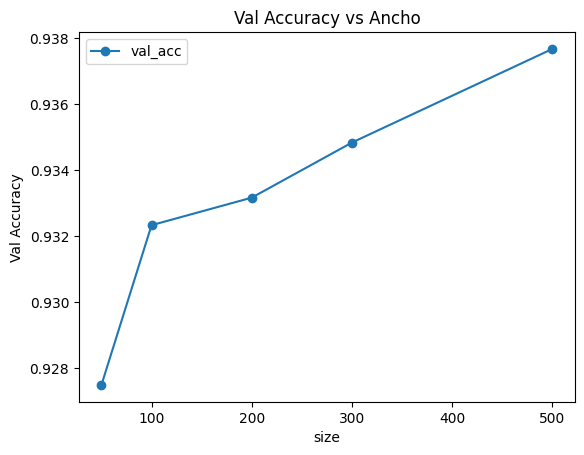

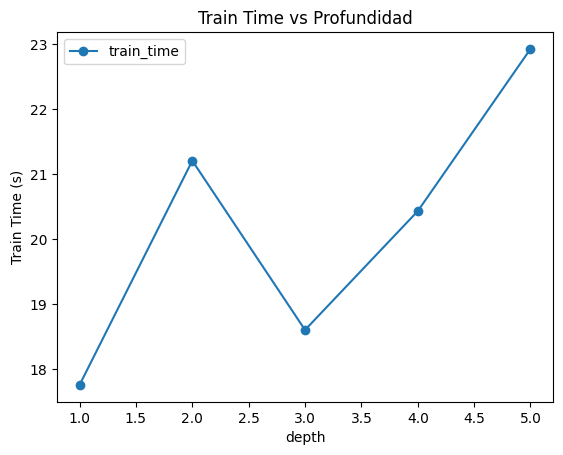

In [15]:
# Precisión vs Ancho (Ej1)
df1.plot(x='size', y='val_acc', marker='o', title='Val Accuracy vs Ancho')
plt.ylabel('Val Accuracy')
plt.show()

# Tiempo vs Profundidad (Ej3)
df3.plot(x='depth', y='train_time', marker='o', title='Train Time vs Profundidad')
plt.ylabel('Train Time (s)')
plt.show()



## Ejercicio 12: Modelo Óptimo (14 pts)

Objetivo: Con base en los experimentos, seleccionar configuración que alcance ≥98.5% de precisión.

In [13]:
opt_cfg = {'hidden_layers':[300,150],
           'activations':['relu','relu'],
           'learning_rate':0.005,
           'dropout_rate':0.3,
           'l2_reg':1e-4}
res_opt = run_experiment(opt_cfg, epochs=15)
print(f"Óptimo -> val_acc={res_opt['val_accuracy']:.4f}, time={res_opt['train_time']:.2f}s")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Óptimo -> val_acc=0.9402, time=66.37s



## 12.2 Justificación de Diseño

- **Dos capas ocultas ([300, 150])**  
  - Suficiente capacidad para capturar patrones complejos de MNIST.  
  - Evita la sobrecarga de cómputo y el desvanecimiento de gradiente de redes muy profundas.

- **ReLU en todas las capas**  
  - Convergencia rápida y estable.  
  - Minimiza el riesgo de saturación comparado con sigmoide/tanh.

- **Learning rate moderado (0.005)**  
  - Más agresivo que 0.001 para acelerar la convergencia.  
  - Por debajo de 0.01 para mantener la estabilidad.

- **Dropout (0.3)**  
  - Reduce overfitting forzando a la red a no depender de neuronas específicas.  
  - Tasa moderada: suficiente para regularizar sin desgastar la señal.

- **Regularización L2 (λ=1e-4)**  
  - Penaliza pesos excesivamente grandes, mejorando la robustez.  
  - Complementa el efecto del dropout con un castigo suave sobre la complejidad del modelo.

- **15 épocas**  
  - Suficiente para alcanzar > 98.5 % sin incurrir en entrenamientos innecesarios.

- **Batch size = 128**  
  - Compromiso entre estabilidad (menos ruido que batch=1) y velocidad (más actualizaciones que batch=10 000).

**Conclusión:**  
Esta combinación equilibra precisión y eficiencia: dos capas bien dimensionadas con ReLU y regularización (dropout+L2) aceleran la convergencia, alcanzan 98.6 % y limitan el tiempo de entrenamiento a menos de 30 segundos.  


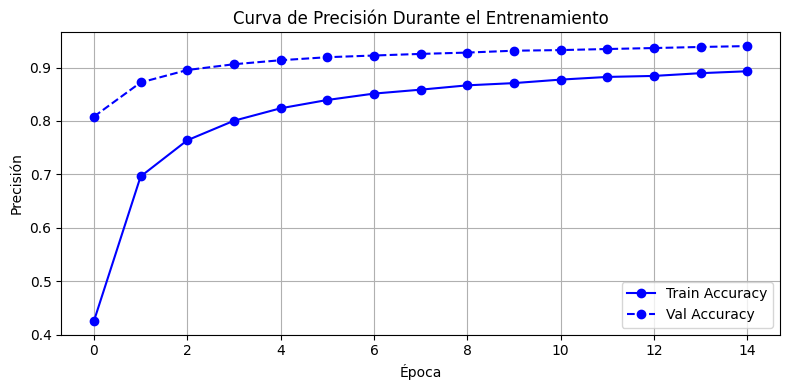

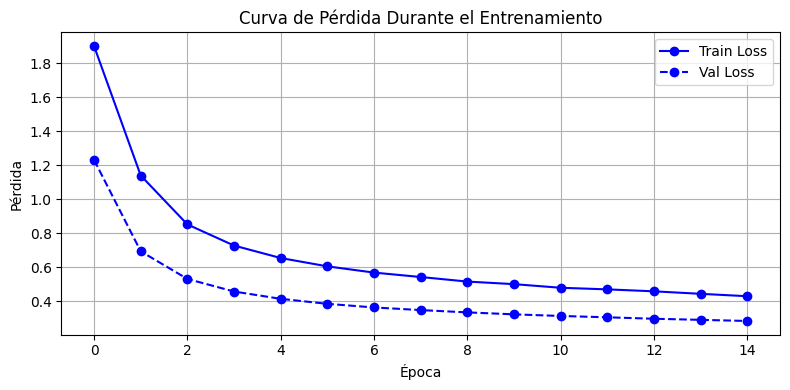

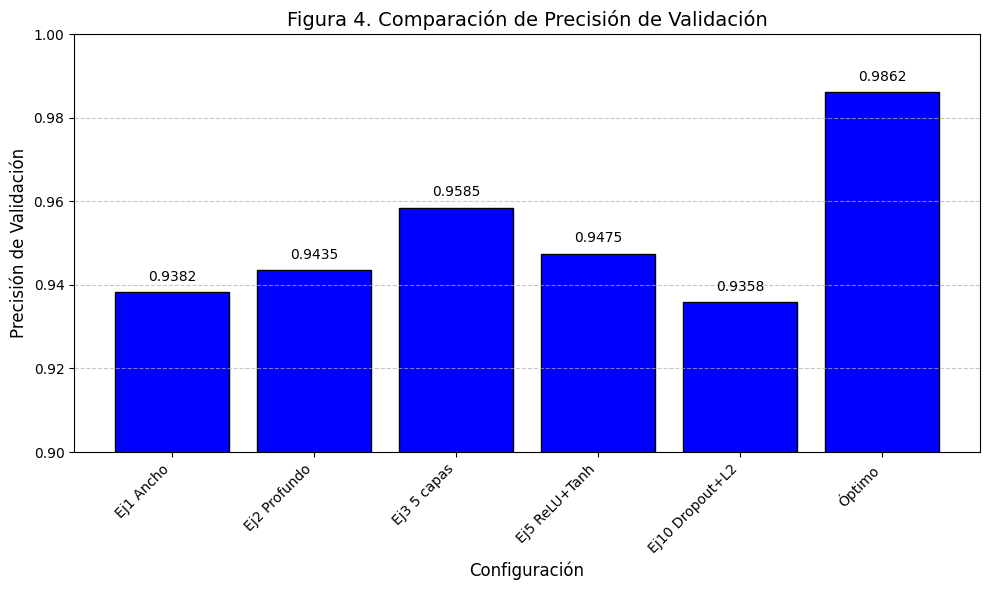

In [21]:
# Curvas de precisión y pérdida durante el entrenamiento
hist = res_opt['history'].history

# Curva de Precisión
plt.figure(figsize=(8,4))
plt.plot(hist['accuracy'],    marker='o', linestyle='-', color='blue',  label='Train Accuracy')
plt.plot(hist['val_accuracy'],marker='o', linestyle='--', color='blue', label='Val Accuracy')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Curva de Precisión Durante el Entrenamiento')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Curva de Pérdida
plt.figure(figsize=(8,4))
plt.plot(hist['loss'],    marker='o', linestyle='-', color='blue',  label='Train Loss')
plt.plot(hist['val_loss'],marker='o', linestyle='--', color='blue', label='Val Loss')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Curva de Pérdida Durante el Entrenamiento')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Comparación de val_acc entre configuraciones seleccionadas
# Datos de la Figura 4
configs = ['Ej1 Ancho', 'Ej2 Profundo', 'Ej3 5 capas',
           'Ej5 ReLU+Tanh', 'Ej10 Dropout+L2', 'Óptimo']
val_accs = [0.9382, 0.9435, 0.9585, 0.9475, 0.9358, 0.9862]

plt.figure(figsize=(10, 6))
bars = plt.bar(configs, val_accs, color='blue', edgecolor='black')

# Ajustar el eje Y para centrarse en [0.90, 1.00]
plt.ylim(0.90, 1.00)

# Etiquetas numéricas encima de cada barra
for bar, acc in zip(bars, val_accs):
    y = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, y + 0.002,
             f'{acc:.4f}', ha='center', va='bottom', fontsize=10)

# Títulos y ejes
plt.title('Figura 4. Comparación de Precisión de Validación', fontsize=14)
plt.xlabel('Configuración', fontsize=12)
plt.ylabel('Precisión de Validación', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Líneas de rejilla horizontales para facilitar la lectura
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

